<a href="https://colab.research.google.com/github/ZiauddinMohammed/POS_Tagging_RNN/blob/master/MP_POS_TAGGING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import theano
import theano.tensor.blas
import numpy as np
import theano.tensor as t
import theano
theano.config.exception_verbosity='high'
import os
import sys
import pickle








Cloning into 'POS_Tagging_RNN'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [0]:
! git clone https://github.com/ZiauddinMohammed/POS_Tagging_RNN/

fatal: destination path 'POS_Tagging_RNN' already exists and is not an empty directory.


In [0]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)
  

In [0]:
class GRU:
    def __init__(self, Mi, Mo, activation):
        self.Mi = Mi
        self.Mo = Mo
        self.f  = activation

        # numpy init
        Wxr = init_weight(Mi, Mo)
        Whr = init_weight(Mo, Mo)
        br  = np.zeros(Mo)
        Wxz = init_weight(Mi, Mo)
        Whz = init_weight(Mo, Mo)
        bz  = np.zeros(Mo)
        Wxh = init_weight(Mi, Mo)
        Whh = init_weight(Mo, Mo)
        bh  = np.zeros(Mo)
        h0  = np.zeros(Mo)

        # theano vars
        self.Wxr = theano.shared(Wxr)
        self.Whr = theano.shared(Whr)
        self.br  = theano.shared(br)
        self.Wxz = theano.shared(Wxz)
        self.Whz = theano.shared(Whz)
        self.bz  = theano.shared(bz)
        self.Wxh = theano.shared(Wxh)
        self.Whh = theano.shared(Whh)
        self.bh  = theano.shared(bh)
        self.h0  = theano.shared(h0)
        self.params = [self.Wxr, self.Whr, self.br, self.Wxz, self.Whz, self.bz, self.Wxh, self.Whh, self.bh, self.h0]

    def recurrence(self, x_t, h_t1):
        r = T.nnet.sigmoid(x_t.dot(self.Wxr) + h_t1.dot(self.Whr) + self.br)
        z = T.nnet.sigmoid(x_t.dot(self.Wxz) + h_t1.dot(self.Whz) + self.bz)
        hhat = self.f(x_t.dot(self.Wxh) + (r * h_t1).dot(self.Whh) + self.bh)
        h = (1 - z) * h_t1 + z * hhat
        return h

    def output(self, x):
        # input X should be a matrix (2-D)
        # rows index time
        h, _ = theano.scan(
            fn=self.recurrence,
            sequences=x,
            outputs_info=[self.h0],
            n_steps=x.shape[0],
        )
        return h

In [0]:
def get_data(split_sequences=False):
    if not os.path.exists('../content/POS_Tagging_RNN/'):
        print("Please create a folder in your local directory called 'chunking'")
        print("train.txt and test.txt should be stored in there.")
        print("Please check the comments to get the download link.")
        exit()
    elif not os.path.exists('../content/POS_Tagging_RNN/train.txt'):
        print("train.txt is not in chunking/train.txt")
        print("Please check the comments to get the download link.")
        exit()
    elif not os.path.exists('../content/POS_Tagging_RNN/test.txt'):
        print("test.txt is not in chunking/test.txt")
        print("Please check the comments to get the download link.")
        exit()

    word2idx = {}
    tag2idx = {}
    word_idx = 0
    tag_idx = 0
    Xtrain = []
    Ytrain = []
    currentX = []
    currentY = []
    for line in open('../content/POS_Tagging_RNN/train.txt'):
        line = line.rstrip()
        if line:
            r = line.split()
            word, tag, _ = r
            if word not in word2idx:
                word2idx[word] = word_idx
                word_idx += 1
            currentX.append(word2idx[word])
            
            if tag not in tag2idx:
                tag2idx[tag] = tag_idx
                tag_idx += 1
            currentY.append(tag2idx[tag])
        elif split_sequences:
            Xtrain.append(currentX)
            Ytrain.append(currentY)
            currentX = []
            currentY = []

    if not split_sequences:
        Xtrain = currentX
        Ytrain = currentY

    # load and score test data
    Xtest = []
    Ytest = []
    currentX = []
    currentY = []
    for line in open('../content/POS_Tagging_RNN/test.txt'):
        line = line.rstrip()
        if line:
            r = line.split()
            word, tag, _ = r
            if word in word2idx:
                currentX.append(word2idx[word])
            else:
                currentX.append(word_idx) # use this as unknown
            currentY.append(tag2idx[tag])
        elif split_sequences:
            Xtest.append(currentX)
            Ytest.append(currentY)
            currentX = []
            currentY = []
    if not split_sequences:
        Xtest = currentX
        Ytest = currentY

    return Xtrain, Ytrain, Xtest, Ytest, word2idx,tag2idx

In [0]:
import numpy as np
import  matplotlib.pyplot as plt
import theano
import theano.tensor as T
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.metrics import f1_score

class RNN:
    def __init__(self, D, hidden_layer_sizes, V, K):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.D = D
        self.V = V
        self.K = K

    def fit(self, X, Y, learning_rate=1e-4, mu=0.99, epochs=30, show_fig=True, activation=T.nnet.relu, RecurrentUnit=GRU, normalize=False):
        D = self.D
        V = self.V
        N = len(X)

        We = init_weight(V, D)
        self.hidden_layers = []
        Mi = D
        for Mo in self.hidden_layer_sizes:
            ru = RecurrentUnit(Mi, Mo, activation)
            self.hidden_layers.append(ru)
            Mi = Mo

        Wo = init_weight(Mi, self.K)
        bo = np.zeros(self.K)

        self.We = theano.shared(We)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.Wo, self.bo]
        for ru in self.hidden_layers:
            self.params += ru.params

        thX = T.ivector('X')
        thY = T.ivector('Y')

        Z = self.We[thX]
        for ru in self.hidden_layers:
            Z = ru.output(Z)
        py_x = T.nnet.softmax(Z.dot(self.Wo) + self.bo)

        testf = theano.function(
            inputs=[thX],
            outputs=py_x,
        )
        testout = testf(X[0])
        print("py_x.shape:", testout.shape)

        prediction = T.argmax(py_x, axis=1)
        
        
        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        dWe = theano.shared(self.We.get_value()*0)
        gWe = T.grad(cost, self.We)
        dWe_update = mu*dWe - learning_rate*gWe
        We_update = self.We + dWe_update
        if normalize:
            We_update /= We_update.norm(2)

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ] + [
            (self.We, We_update), (dWe, dWe_update)
        ]
        
        
        self.predict_op=theano.function(
            inputs=[thX],
            outputs=[prediction],
        )

        self.cost_predict_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            allow_input_downcast=True,
        )

        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates
        )

        costs = []
        sequence_indexes = range(N)
        n_total = sum(len(y) for y in Y)
        for i in range(epochs):
            t0 = datetime.now()
            sequence_indexes = shuffle(sequence_indexes)
            n_correct = 0
            cost = 0
            it = 0
            for j in sequence_indexes:
                c, p = self.train_op(X[j], Y[j])
                cost += c
                n_correct += np.sum(p == Y[j])
                it += 1
                if it % 200 == 0:
                    sys.stdout.write(
                        "j/N: %d/%d correct rate so far: %f, cost so far: %f\r" %
                        (it, N, float(n_correct)/n_total, cost)
                    )
                    sys.stdout.flush()
            print(
                "i:", i+1, "cost:", cost,
                "correct rate:", (float(n_correct)/n_total),
                "time for epoch:", (datetime.now() - t0)
            )
            costs.append(cost)
            

        if show_fig:
            plt.plot(costs)
            plt.show()
    
    def predict(self,X):
        for x in X:
            p=self.predict_op(x)
            #print(p)
            return p
         
        

    def score(self, X, Y):
        n_total = sum(len(y) for y in Y)
        n_correct = 0
        for x, y in zip(X, Y):
            _, p = self.cost_predict_op(x, y)
            n_correct += np.sum(p == y)
        return float(n_correct) / n_total

    def f1_score(self, X, Y):
        P = []
        for x, y in zip(X, Y):
            _, p = self.cost_predict_op(x, y)
            P.append(p)
        Y = np.concatenate(Y)
        P = np.concatenate(P)
        return f1_score(Y, P, average=None).mean()








In [0]:
def flatten(l):
    return [item for sublist in l for item in sublist]


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


py_x.shape: (37, 44)
i: 1 cost: 27509.42913051135 correct rate: 0.1627567575226589 time for epoch: 0:00:22.990371
i: 2 cost: 17923.97920259564 correct rate: 0.4450967519494443 time for epoch: 0:00:23.098202
i: 3 cost: 12209.847928754973 correct rate: 0.5993756110463002 time for epoch: 0:00:22.884809
i: 4 cost: 8543.296308388815 correct rate: 0.7298927392349582 time for epoch: 0:00:22.764033
i: 5 cost: 6052.439423051279 correct rate: 0.820632229238595 time for epoch: 0:00:22.926709
i: 6 cost: 4465.676738657936 correct rate: 0.8707911603149339 time for epoch: 0:00:22.834651
i: 7 cost: 3442.302486948828 correct rate: 0.9004850585895988 time for epoch: 0:00:23.787872
i: 8 cost: 2781.472985148372 correct rate: 0.9203880468716791 time for epoch: 0:00:22.833799
i: 9 cost: 2346.815443893448 correct rate: 0.9334378704652689 time for epoch: 0:00:22.872914
i: 10 cost: 2033.9255807271443 correct rate: 0.9435641179443339 time for epoch: 0:00:22.884012
i: 11 cost: 1779.2325618600134 correct rate: 0.

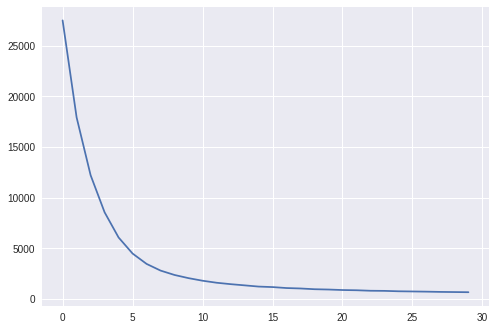

train score: 0.9804181800148304
test score: 0.9295016569221353


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train f1: 0.8339224633821574
test f1: 0.7974474814485593


In [0]:
Xtrain, Ytrain, Xtest, Ytest, word2idx, tag2idx = get_data(split_sequences=True)
V = len(word2idx) + 1
K = len(set(flatten(Ytrain)) | set(flatten(Ytest)))
rnn = RNN(10, [10], V, K)
rnn.fit(Xtrain, Ytrain)
print("train score:", rnn.score(Xtrain, Ytrain))
print("test score:", rnn.score(Xtest, Ytest))
print("train f1:", rnn.f1_score(Xtrain, Ytrain))
print("test f1:", rnn.f1_score(Xtest, Ytest))

In [0]:
ip_text=input()
ip_words=[]
for word in ip_text.split():
  ip_words.append(word)


ip_list=[]
ip_idx=[]
found_words=[]
na_words=[]
for word in ip_words:
  try:
    ip_idx.append(word2idx[word])
    ip_list.append(ip_idx)
    found_words.append(word)
  except: 
    na_words.append(word)

pred_tags=rnn.predict(ip_list[0:1])

tags=[]

try:
  for i in pred_tags[0]:
    for key,val in tag2idx.items():
      if val==i:
        tags.append(key)
except:
  print("",end="\t")

if(len(tags)!=0):
  print("\nTags-Found")
for word,tag in zip(found_words,tags):     
  print(word,":",tag,end="\t")

if(len(na_words)!=0):
  print("\n\nTags-Not Found")
  for word in na_words:
    print(word,":N/A",end="\t")

shut up

Tags-Found
shut : VBN	up : IN	

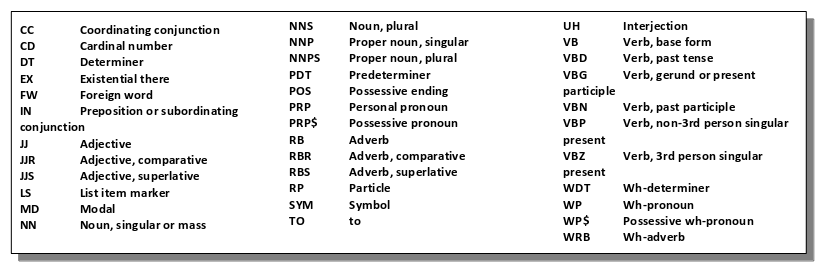

In [0]:
from IPython.display import display, Image
display(Image(filename='../content/POS_Tagging_RNN/nltk-speech-codes (1).png'))
